In [5]:
import matplotlib.pyplot as plt
import pickle
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier, plot_tree
from comparers import ModelComparer, plot_decision_boundary
from diro2c_wrapper import WrappedDiro2C, plot_diro2c_2d, plot_diro2c_tree, \
                           print_diro2c_rules
from baseline import print_rules, plot_tree_leafs_for_class
from tasks.adult import make_task_with_influential_and_uninfluential_modification as make_task
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

In [6]:
clf_a, clf_b, X, X_display, y, feature_names = make_task()

The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].


[16:51:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[16:51:17] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
[16:51:18] WARNING: /Users/travis/build/dmlc/xgboost/src/learner.cc:573: 
Parameters: { "nestimators" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above c

In [7]:
comparer = ModelComparer(clf_a, clf_b, feature_names)

# Local explanations

In [8]:
is_diff = comparer.predict_bin_diff(X)
mclass_diff = comparer.predict_mclass_diff(X)

## $(False, True)$

In [9]:
focus_class = '(False, True)'

In [10]:
explainer = WrappedDiro2C(X, comparer, focus_class)

In [11]:
instance_indices = np.where(comparer.class_names[mclass_diff] == focus_class)[0]

In [12]:
%%time
explanations = []
for i, instance_idx in enumerate(instance_indices, 1):
    print(f'{i}/{len(instance_indices)}')
    explanation = explainer.generate_local_explanation(instance_idx)
    explanations.append(explanation)
with open(f'diro2c.{focus_class}.test.pickle', 'wb') as f:
    pickle.dump((explainer, explanations), f, pickle.HIGHEST_PROTOCOL)

1/14
2/14
3/14
4/14
5/14
6/14
7/14
8/14
9/14
10/14
11/14
12/14
13/14
14/14
CPU times: user 2h 37min 39s, sys: 8min 21s, total: 2h 46min 1s
Wall time: 49min 16s


In [13]:
with open(f'diro2c.{focus_class}.test.pickle', 'rb') as f:
    explainer, explanations = pickle.load(f)

In [14]:
class_names = explanations[0]['class_names']
feature_names = comparer.feature_names

In [15]:
X_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['X']
                            for explanation in explanations])
y_explain = np.concatenate([explanation['binary_diff_classifer']['evaluation_info']['y']
                            for explanation in explanations])

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


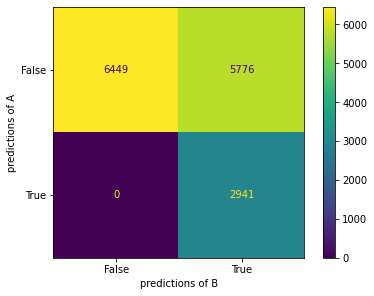

In [16]:
comparer.plot_confusion_matrix(X_explain)

In [17]:
# Check for errors
is_explain_diff = explainer.clf_a.predict(X_explain) != explainer.clf_b.predict(X_explain)
(is_explain_diff != y_explain).sum(), len(y_explain)

Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption


(0, 15166)

In [18]:
def explain(max_depth=None, tree_fig_size=(14, 14)):
    global tree
    tree = DecisionTreeClassifier(max_depth=max_depth)
    tree.fit(X_explain, y_explain)
    
    feature_importances = tree.feature_importances_
    feature_order = np.flip(np.argsort(feature_importances))
    fig, ax = plt.subplots(figsize=(7, 5))
    ax.set_title('Relative feature importance')
    ax.scatter(np.flip(feature_importances[feature_order]),
               np.flip(comparer.feature_names[feature_order]))
    plt.show()
    
    fig, ax = plt.subplots(figsize=tree_fig_size)
    plot_tree(tree, feature_names=feature_names, class_names=class_names, ax=ax, node_ids=True, precision=1)
    
    y_test = mclass_diff == np.where(comparer.class_names == focus_class)[0][0]
    print_rules(tree, feature_names, class_names, focus_class, X_test=X, y_test=y_test, precision=1,
                feature_order=feature_order)
    
    plot_tree_leafs_for_class(tree, class_names, focus_class, X, mclass_diff, comparer.class_names,
                              feature_names)
    
    print('\ngenerated data evaluation:')
    print(classification_report(y_explain, tree.predict(X_explain), target_names=class_names))

    print('\noriginal data evaluation:')
    print(classification_report(mclass_diff == np.where(comparer.class_names == focus_class)[0][0],
                                tree.predict(X), target_names=class_names))

- rule 1 (node 11/11): equal
- rule 2 (node 9/13): equal
original model has one more rule, which just covers a single instance.

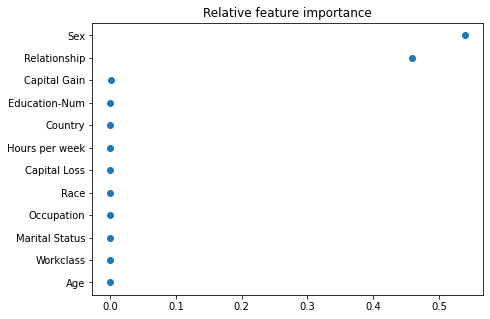

node #11: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) then class (False, True) (covers 0.672 of 6424 instances)
node #13: if (Sex <= 0.3) and (Relationship > 4.2) then class (False, True) (covers 0.683 of 1522 instances)
number of rules: 2
number of terms: 5 (2.5 avg. per rule)

generated data evaluation:
                   precision    recall  f1-score   support

not (False, True)       0.94      0.72      0.82      9390
    (False, True)       0.67      0.93      0.78      5776

         accuracy                           0.80     15166
        macro avg       0.81      0.83      0.80     15166
     weighted avg       0.84      0.80      0.80     15166


original data evaluation:
                   precision    recall  f1-score   support

not (False, True)       1.00      0.57      0.73       963
    (False, True)       0.03      1.00      0.06        14

         accuracy                           0.58       977
        macro avg       0.52      0.79      0.40 

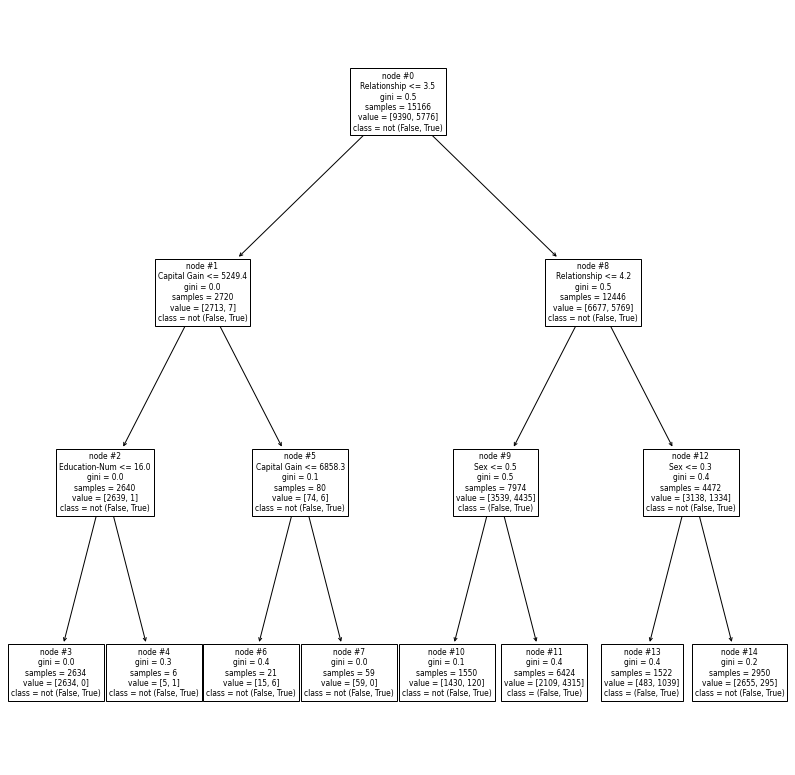

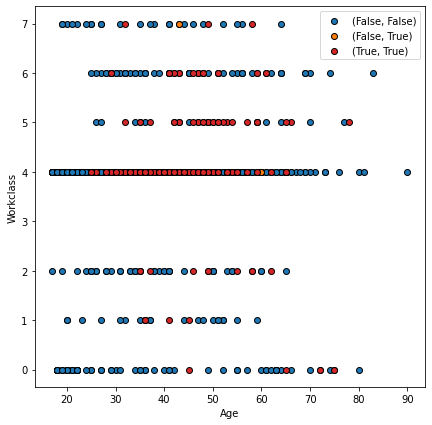

In [19]:
explain(max_depth=3)

- rule 1 (node 20/19): Hours per week instead of Marital status
- rule 2 (node 16/23): equal
- rule 3 (node 24/25): Relationship instead of Marital Status

the rest is not similar (1 additional rule in original explanation, 3 additional rules in test explanation)

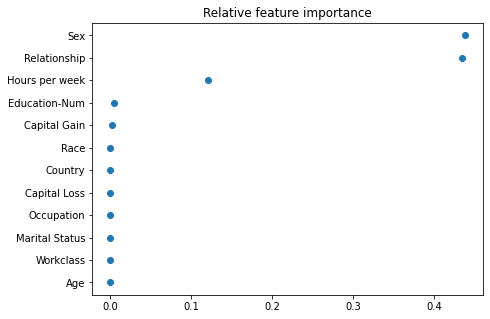

node #19: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Hours per week > 39.6) then class (False, True) (covers 0.724 of 5942 instances)
node #23: if (Sex <= 0.3) and (Relationship > 4.7) then class (False, True) (covers 0.782 of 1301 instances)
node #25: if (Sex > 0.3) and (Relationship > 4.2) and (Relationship <= 4.3) then class (False, True) (covers 0.602 of 83 instances)
node #16: if (Sex <= 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Education-Num > 13.3) then class (False, True) (covers 0.621 of 29 instances)
node #10: if (Relationship <= 3.5) and (Capital Gain > 6609.8) and (Capital Gain <= 6858.3) then class (False, True) (covers 0.714 of 7 instances)
node #5: if (Relationship <= 3.5) and (Education-Num > 16.0) and (Capital Gain <= 5249.4) and (Race <= 2.9) then class (False, True) (covers 1.0 of 1 instances)
number of rules: 6
number of terms: 20 (3.3 avg. per rule)

generated data evaluation:
                   precision    recall  f1

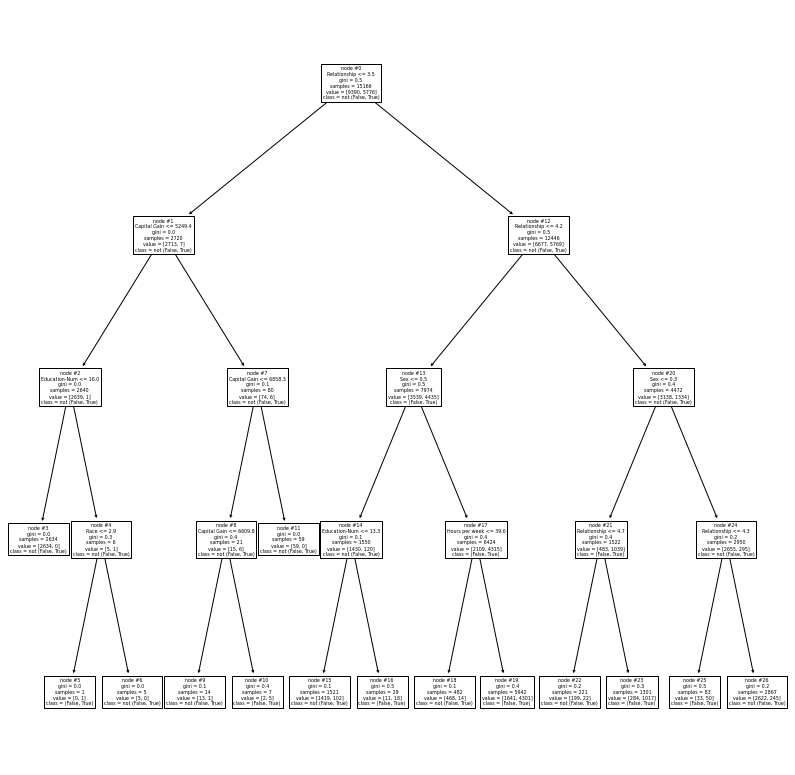

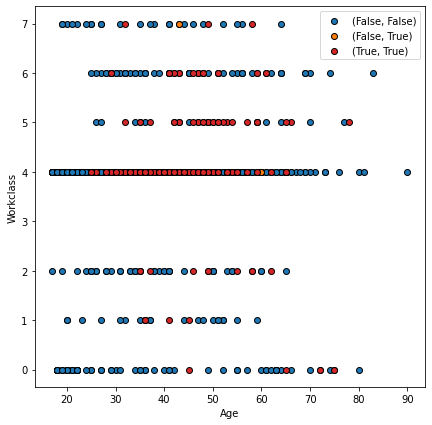

In [20]:
explain(max_depth=4)

- rule 1 (node 36/30): equal
- rule 2 (node 28/39): Hours per week instead of Education-Num

The rest is not similar.

Interesting: test explanation rule 4 of node 43 restricts relationship to $>4.2 \land \leq 4.3$. This range includes no valid values and is a result of the method not supporting categorical values.

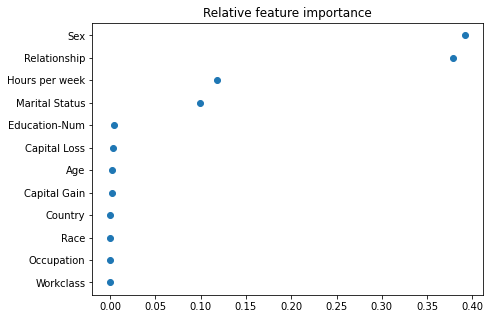

node #30: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Hours per week > 39.6) and (Marital Status <= 2.3) then class (False, True) (covers 0.791 of 5261 instances)
node #39: if (Sex <= 0.3) and (Relationship > 4.7) and (Hours per week > 40.0) then class (False, True) (covers 0.892 of 804 instances)
node #38: if (Sex <= 0.3) and (Relationship > 4.7) and (Hours per week <= 40.0) then class (False, True) (covers 0.604 of 497 instances)
node #43: if (Sex > 0.7) and (Relationship > 4.2) and (Relationship <= 4.3) then class (False, True) (covers 0.774 of 62 instances)
node #21: if (Sex <= 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Education-Num <= 13.3) and (Capital Loss > 2026.0) then class (False, True) (covers 0.533 of 30 instances)
node #23: if (Sex <= 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Education-Num > 13.3) and (Age <= 30.0) then class (False, True) (covers 0.895 of 19 instances)
node #13: if (Relationship <= 3.0) and

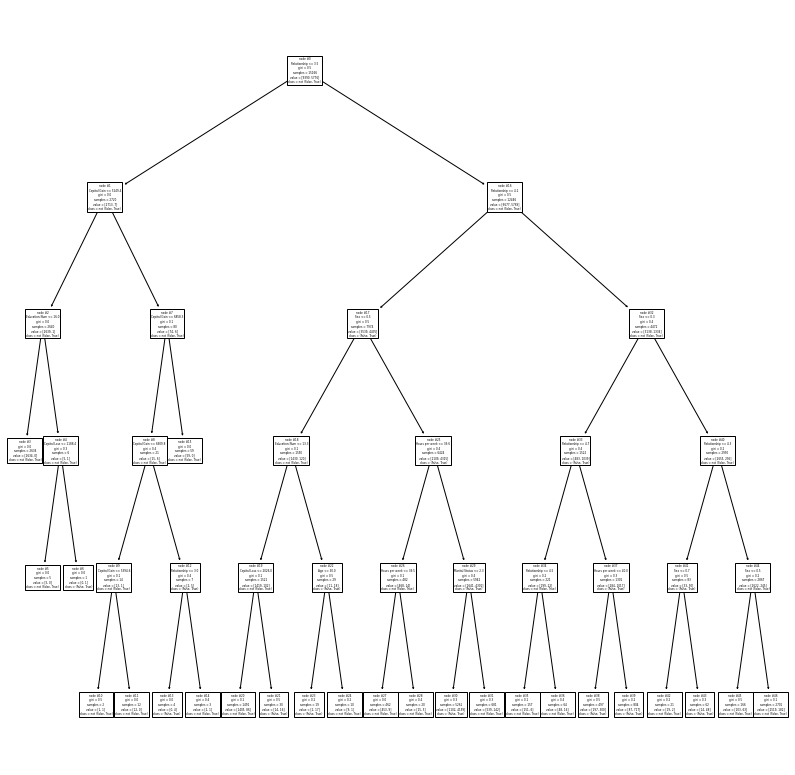

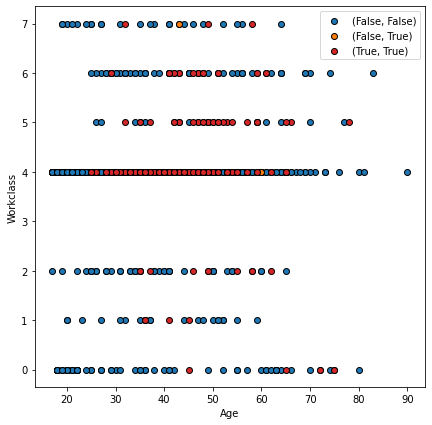

In [21]:
explain(max_depth=5)

- rule 1 (node 64/48): equal
- rule 2 (node 63/47): equal
- rule 3 (node 47/66): Hours per week replaces Marital status, Education-Num lower 

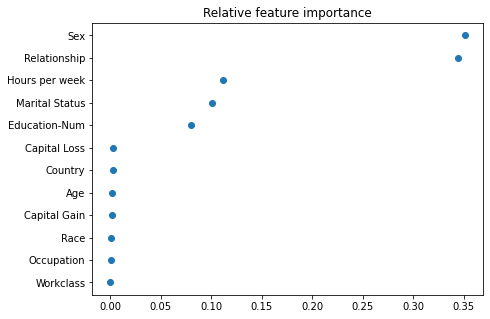

node #48: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Hours per week > 39.6) and (Marital Status <= 2.3) and (Education-Num > 10.6) then class (False, True) (covers 0.893 of 3407 instances)
node #47: if (Sex > 0.5) and (Relationship > 3.5) and (Relationship <= 4.2) and (Hours per week > 39.6) and (Marital Status <= 2.3) and (Education-Num <= 10.6) then class (False, True) (covers 0.603 of 1854 instances)
node #66: if (Sex <= 0.3) and (Relationship > 4.7) and (Hours per week > 40.0) and (Hours per week <= 42.2) then class (False, True) (covers 0.908 of 790 instances)
node #64: if (Sex <= 0.3) and (Relationship > 4.7) and (Hours per week <= 40.0) and (Education-Num > 12.6) then class (False, True) (covers 0.837 of 356 instances)
node #79: if (Sex > 0.3) and (Sex <= 0.5) and (Relationship > 5.0) then class (False, True) (covers 0.659 of 88 instances)
node #75: if (Sex > 0.7) and (Relationship > 4.2) and (Relationship <= 4.3) and (Hours per week > 39.7) then clas

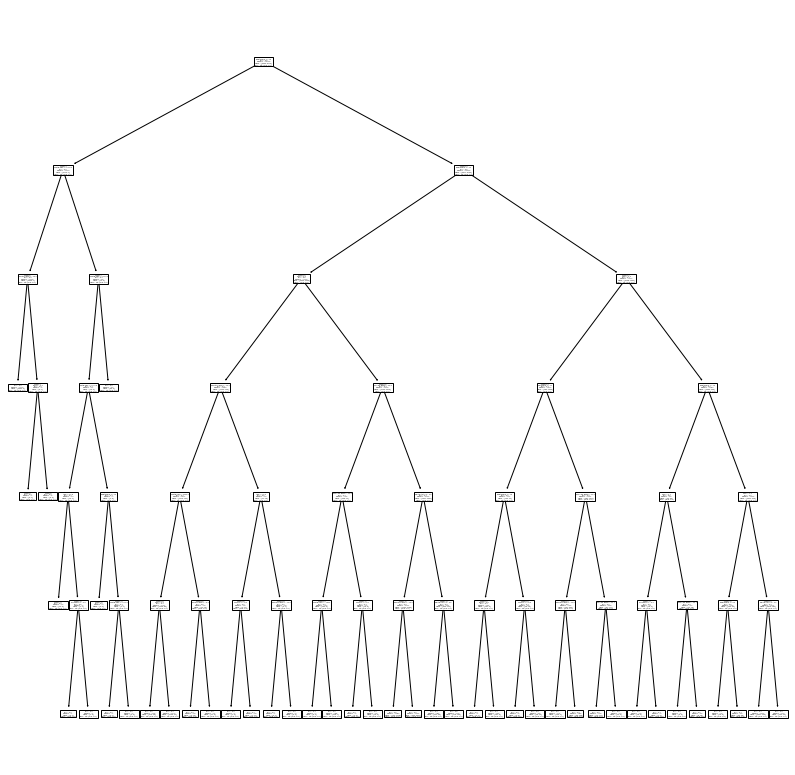

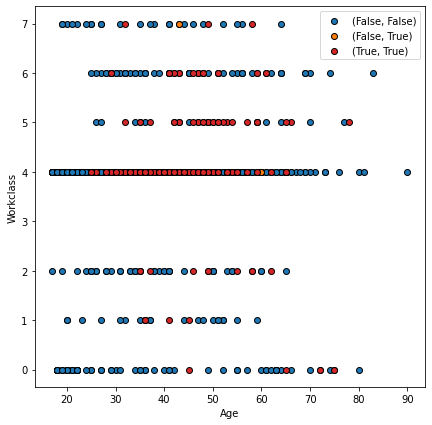

In [22]:
explain(max_depth=6)